# Import

In [5]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector, ConvLSTM1D, Flatten
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import keras
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from scipy.signal import savgol_filter

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=8, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)


from modules.Utils.utils import loadFromDB, strategyTester, computeStochasticLinearRegression
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures


# Get data

In [14]:
SYMBOL= 'BTC'
df = loadFromDB(f'./Data/1h/{SYMBOL}-USDT.csv')
df['Close_filtered'] = savgol_filter(df['Close'].values, 25, 2,mode='nearest')
print(f"Total records : {len(df)} rows")
df.head()

Total records : 23452 rows


,Open,High,Low,Close,Volume,Timestamp,Close_filtered
Date,,,,,,,
2020-01-01 01:00:00,7195.24,7196.25,7175.46,7177.02,511.814901,1577836800,7198.094839
2020-01-01 02:00:00,7176.47,7230.00,7175.71,7216.27,883.052603,1577840400,7200.489362
2020-01-01 03:00:00,7215.52,7244.87,7211.41,7242.85,655.156809,1577844000,7202.982883
2020-01-01 04:00:00,7242.66,7245.00,7220.00,7225.01,783.724867,1577847600,7204.882562
2020-01-01 05:00:00,7225.00,7230.00,7215.03,7217.27,467.812578,1577851200,7206.463384


# Trying to denoise.

## Normalize data

In [15]:
WINDOW = 100
INDEXING_WINDOW = 1

df['Close_filtered_norm'] = (df.Close_filtered-df.Close_filtered.mean())/df.Close_filtered.std()
df['Close_norm'] = (df.Close-df.Close.mean())/df.Close.std()

## Train and Test training

In [16]:
#df =  df.iloc[-5000:]

X = np.array([df.Close_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[:-INDEXING_WINDOW]
y = np.array([df.Close_filtered_norm.iloc[i:i+WINDOW].values.reshape(1,-1) for i in range(len(df)-WINDOW)])[INDEXING_WINDOW:]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

(39939, 1, 100)


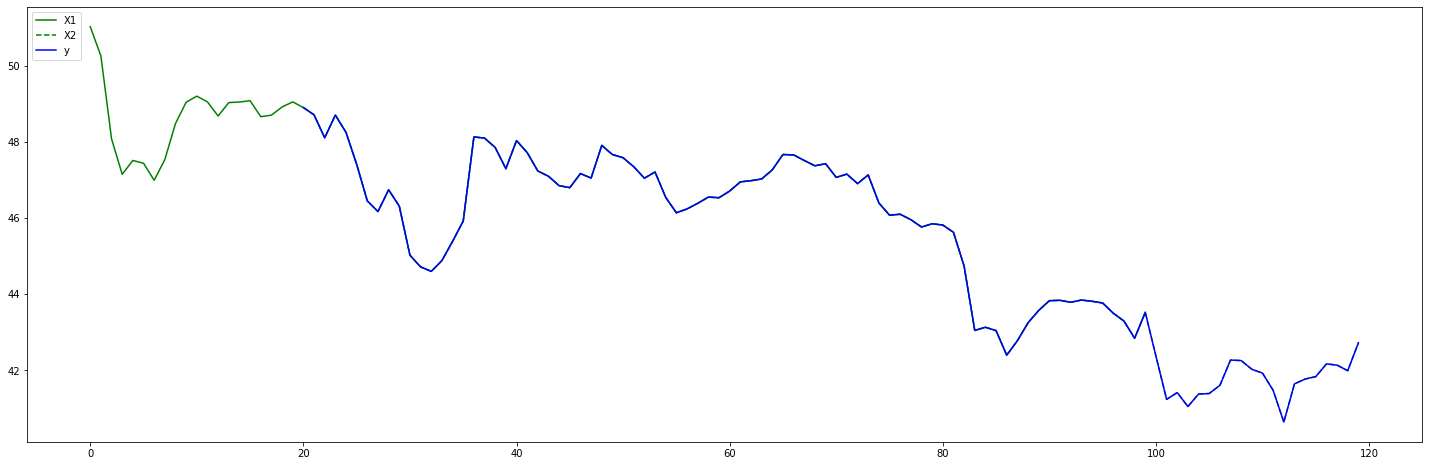

In [102]:
fig, ax_left = plt.subplots(1, figsize=(25,8))


ax_left.plot(list(range(len(X[0][0]))),X[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X1')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(X[INDEXING_WINDOW][0]))],X[INDEXING_WINDOW][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='X2', linestyle='--')
ax_left.plot([i+INDEXING_WINDOW for i in range(len(y[INDEXING_WINDOW][0]))],y[0][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='blue',label='y')
ax_left.legend(loc="upper left")
print(X_train.shape)

### Only dense

In [42]:
input_window = Input(shape=(1,WINDOW))
encoded = Dense(10, activation='relu')(input_window)
inter_1 = Dense(30, activation='relu')(encoded)
decoded = Dense(WINDOW, activation='linear')(inter_1)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 100)]          0         
                                                                 
 dense_22 (Dense)            (None, 1, 10)             1010      
                                                                 
 dense_23 (Dense)            (None, 1, 30)             330       
                                                                 
 dense_24 (Dense)            (None, 1, 100)            3100      
                                                                 
Total params: 4,440
Trainable params: 4,440
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
47/47 [==============================] - 2s 22ms/step - loss: 0.6746 - val_loss: 0.0985
Epoch 2/200
47/47 [==============================] - 0s 11ms/step - loss: 0.1067 - val_l

### With LSTM

In [17]:
input_window = Input(shape=(1,WINDOW))
encoded = LSTM(4, kernel_initializer='he_uniform', return_sequences=True, name='encoder_1')(input_window)
encoded_2 = Dense(10, activation='relu',)(encoded)
norm_1 = BatchNormalization()(encoded_2)
inter_1 = Dense(30, activation='relu')(norm_1)
norm_2 = BatchNormalization()(inter_1)
decoded = Dense(WINDOW, activation='linear')(norm_2)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

history = autoencoder.fit(X, y,
                epochs=200,
                batch_size=1024,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stop])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 100)]          0         
                                                                 
 encoder_1 (LSTM)            (None, 1, 4)              1680      
                                                                 
 dense_6 (Dense)             (None, 1, 10)             50        
                                                                 
 batch_normalization_4 (Batc  (None, 1, 10)            40        
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 1, 30)             330       
                                                                 
 batch_normalization_5 (Batc  (None, 1, 30)            120       
 hNormalization)                                           

In [18]:
predictions = autoencoder.predict(X)
print(len(X))
print(len(predictions))

57075
57075


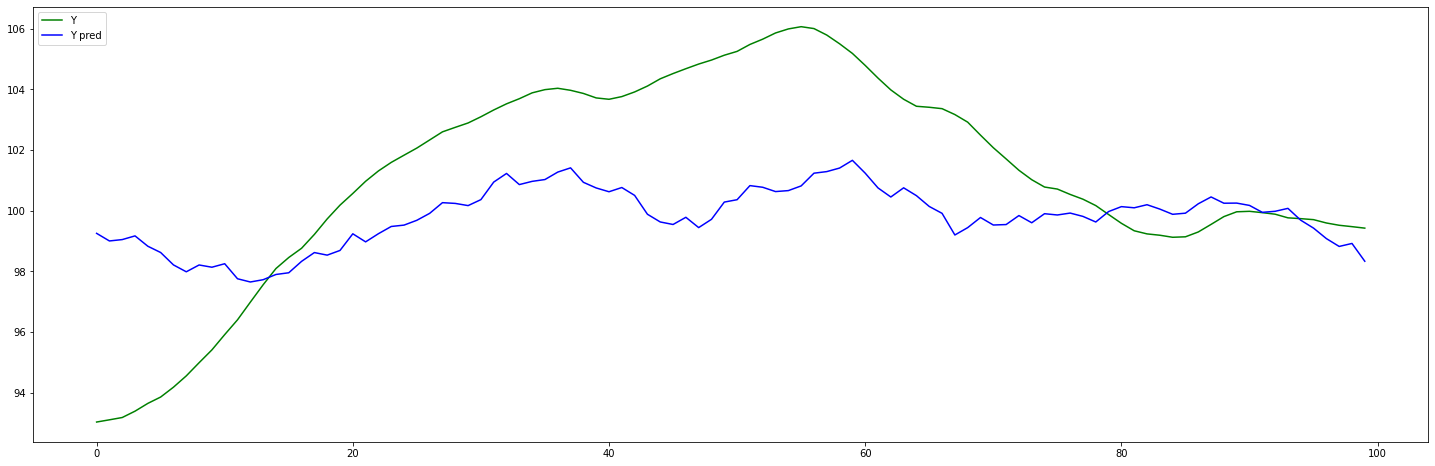

In [21]:
index = -1004

fig, ax_left = plt.subplots(1, figsize=(25,8))


ax_left.plot(list(range(len(y[index][0]))),y[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(),color='green',label='Y')
ax_left.plot(list(range(len(predictions[index][0]))),savgol_filter(predictions[index][0]*df.Close_filtered.std()+df.Close_filtered.mean(), 25, 2,mode='nearest'),color='blue',label='Y pred')
ax_left.legend(loc="upper left")

# Denoising with KNN

In [9]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import pywt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.signal import savgol_filter
import statsmodels as sm


In [15]:
df = computeLaggingLinearRegression(df,'Close',20,False, False,False)
df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'], 25, 2,mode='nearest')
df.head()

,Open,High,Low,Close,Volume,Timestamp,Close_filtered,B_MLR_coefs,B_MLR_coefs_filtered
Date,,,,,,,,,
2020-01-01 21:00:00,7229.48,7242.98,7224.68,7236.73,391.834174,1577908800,7222.160846,0.000375,0.000411
2020-01-01 22:00:00,7237.26,7242.75,7227.00,7233.17,285.454078,1577912400,7214.957009,0.000261,0.000365
2020-01-01 23:00:00,7233.32,7234.49,7186.00,7197.99,769.030411,1577916000,7206.270723,0.000280,0.000287
2020-01-02 00:00:00,7197.62,7204.17,7175.15,7200.85,811.250160,1577919600,7198.765086,0.000268,0.000180
2020-01-02 01:00:00,7200.77,7212.50,7185.46,7211.02,391.352377,1577923200,7189.048580,0.000209,0.000049


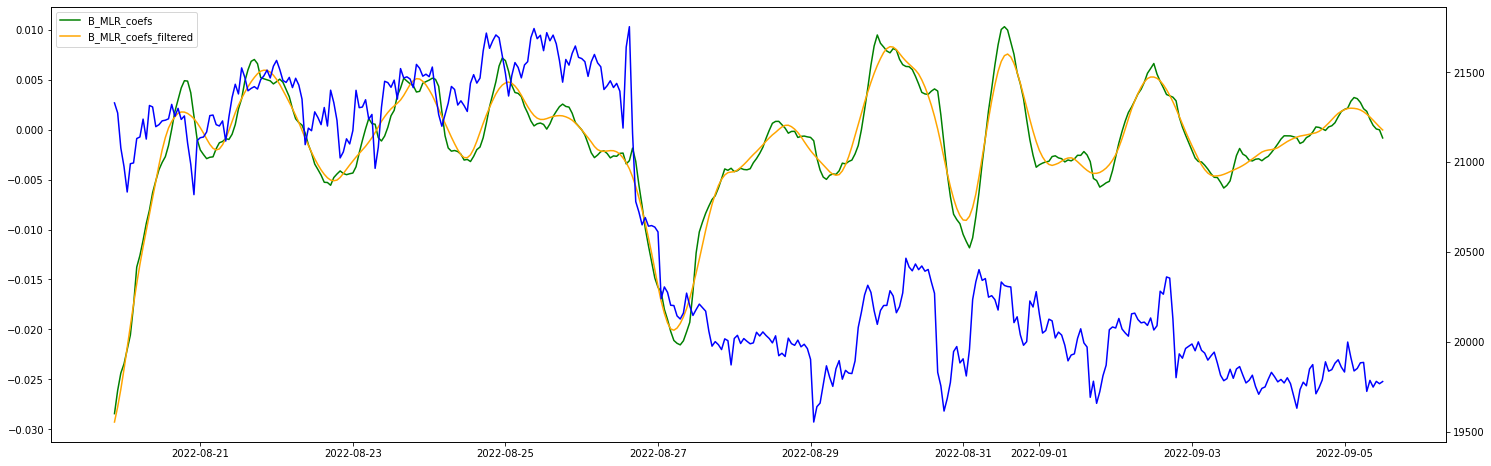

In [17]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(df.Timestamp.values, df.B_MLR_coefs.values, bc_type='natural')

df['Close_pred'] = cs(df.Timestamp.values.reshape(-1, 1))

window_to_see = 400
df_see = df.iloc[-window_to_see:]
fig, ax_left = plt.subplots(1, figsize=(25,8))

ax_left.plot(df_see.B_MLR_coefs, color='green',label='B_MLR_coefs')
ax_left.plot(df_see.B_MLR_coefs_filtered, color='orange',label='B_MLR_coefs_filtered')
ax = ax_left.twinx()
ax.plot(df_see.Close, color='blue',label='Close')
ax_left.legend(loc="upper left")